<a href="https://colab.research.google.com/github/mrromaniuc/quantum-computing/blob/main/QC_Particle_Swarm_Optimization_SingleQubitV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initializing and installing libraries

In [1]:
%%capture
!pip install qiskit -U
!pip install pylatexenc
!pip install imgaug==0.2.5
!pip install kaleidoscope

In [2]:
#Setting configuration to use matplotlib in drawings
!mkdir ~/.qiskit
!echo "[default]" > ~/.qiskit/settings.conf
!echo "circuit_drawer = mpl" >> ~/.qiskit/settings.conf
!more ~/.qiskit/settings.conf

import qiskit.tools.jupyter
%qiskit_version_table

mkdir: cannot create directory ‘/root/.qiskit’: File exists
[default]
circuit_drawer = mpl


#Simple quantum classifier



## The dataset

### Creating the Dataset

In [3]:
import numpy as np
import pandas as pd

np.random.seed(42)

def make_classification(n_samples):
  feat1zero = np.random.uniform(-1      ,1, size=n_samples//2)
  feat1one  = np.random.uniform(+1      ,3, size=n_samples//2)
  feat1     = np.append(feat1zero, feat1one)

  feat2zero = np.random.uniform(-1      ,1, size=n_samples//2)
  feat2one  = np.random.uniform(-1      ,1, size=n_samples//2)
  feat2 = np.append(feat2zero, feat2one)

  label = np.append(np.zeros(n_samples//2), np.ones(n_samples//2))

  return pd.DataFrame({'feat1':feat1, 'feat2':feat2, 'label':label})

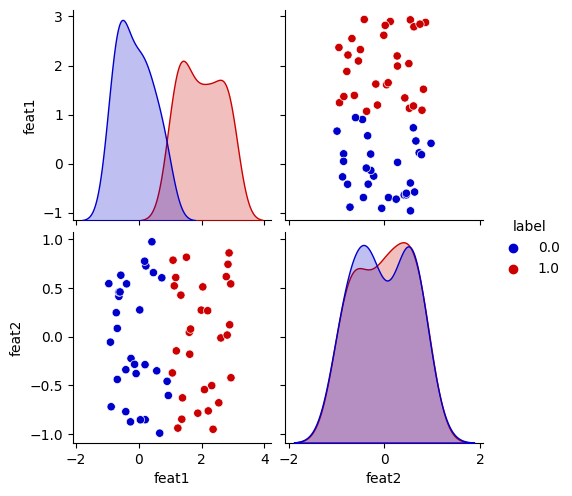

In [4]:
import seaborn as sns

n_samples = 60

df = make_classification(n_samples)

#blue -> 0
#red   -> 1
colors={0:'#0000cc', 1:'#cc0000'}
alpha= 1

sns.pairplot(data=df, hue="label", palette=colors)

### Mapping features to angles

In [5]:
from sklearn.preprocessing import MinMaxScaler

sep = 0

f1Range = (-np.pi/2+sep, 1.5*np.pi-sep)
f2Range = (-np.pi/2+sep, np.pi/2-sep)

ScalerYZ   = MinMaxScaler(feature_range=f1Range)          #Scaler for rotations in the YZ plan (avoiding the poles)
ScalerXY   = MinMaxScaler(feature_range=f2Range)          #Scaler for rotations in the XY plan (using the entire circunference)

feat1Data = ScalerYZ.fit_transform(df[['feat1']])
feat1Data = feat1Data.reshape([1, feat1Data.shape[0]])[0]
feat2Data = ScalerXY.fit_transform(df[['feat2']])
feat2Data = feat2Data.reshape([1, feat2Data.shape[0]])[0]

dsFinal = pd.DataFrame({"feat1": feat1Data, "feat2":feat2Data, "label":df["label"]})

X = dsFinal[["feat1","feat2"]].to_numpy()
y = dsFinal["label"].to_numpy()

In [28]:
dsFinal.head(5)

feat1     feat2  label
0 -1.123687 -0.551859    0.0
1 -0.752971  1.559260    0.0
2 -1.096386  0.284252    0.0
3 -1.394932 -0.949926    0.0
4 -1.286974 -1.403496    0.0

##The quantum *circuit*

###Embedding - parameters and encoding

In [6]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.compiler import transpile
import math
import numpy as np

n_qubits     = 1
n_params     = 2

#Create Quantum Circuit Embedding parameters
def create_qcep(n_params):
  qcep = {}
  for i in range(0, n_params):
    pname1 = (str(i)).rjust(2,"0")
    qcep[i] = Parameter("e" + pname1)
  return qcep

#print(qcep)

#Assign parameters to the quantum circuit qc, based on the list of parameters qcparams and the values of the parameters, passed by pvals
def assign_params(qc, qcparams, pvals):
  if (len(pvals) != len(qcparams)):
    raise Exception(f"Invalid Number of parameters. Expected {len(qcparams)}. Receiverd {len(pvals)}")

  result_qc = qc.copy()
  for idx in range(0, len(pvals)):
    result_qc.assign_parameters({qcparams[idx]: pvals[idx]}, inplace=True)
  return result_qc


#Create the Quantum Circuit responsible for the encoding
def create_encoding_qc(qcep, n_qubits):
  qce = QuantumCircuit(n_qubits)

  for q in range(0, n_qubits):
    qce.rx(qcep[2*q], q)
    qce.ry(qcep[2*q+1], q)

  qce.barrier()
  return qce

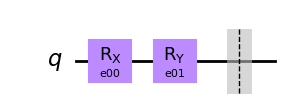

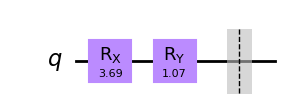

In [7]:
qcep = create_qcep(n_params)
qce = create_encoding_qc(qcep, n_qubits)
qce_trans = transpile(qce)
qce_ready = assign_params(qce_trans, qcep, [3.693450 	,1.070796 	]) #parameter input happens here - just a test
display(qce.draw())
display(qce_ready.draw())


### Displaying how the dataset is placed in the Bloch Sphere after the embedding

In [8]:
import kaleidoscope.qiskit
from kaleidoscope import bloch_sphere
from qiskit.quantum_info import partial_trace, DensityMatrix, Statevector
from qiskit import Aer

def plot_bloch(X, y, qc, qcep, colors, alpha=1):
#X - Statevectors
#y - zeros or ones
  if (not len(X)):
    return None

  svs = []
  for x in X:
    qce_ready = assign_params(qc, qcep, x) #parameter input happens here
    sv = Statevector.from_label('0')
    sv = sv.evolve(qce_ready)
    svs.append(sv)

  zeros = [calcXYZ(sv) for sv, y in zip(svs, y) if y==0  ]
  ones  = [calcXYZ(sv) for sv, y in zip(svs, y) if y==1  ]

  return bloch_sphere(points=[zeros, ones],
             points_color=colors,
             points_alpha=[alpha*np.ones(len(zeros)), alpha*np.ones(len(ones))],
             figsize=(500, 500))


def calcXYZ(sv):
  dm = DensityMatrix(sv)
  a = dm.data[0,0]
  b = dm.data[1,0]
  x = 2.0*b.real
  y = 2.0*b.imag
  z = 2.0*a.real -1.0
  return [x,y,z]


plot_bloch(X, y, qce_trans, qcep, colors)

### The processing circuit - Ansatz

In [9]:
from qiskit import Aer

#Initialize quantum circuit parameter list for circuit...
def create_qcpp(n_params):
  qcpp = {}
  for p in range(0, n_params):
    name = "p" + str(p).rjust(2,'0')
    qcpp[p] = Parameter(name)
  return qcpp

#Create the processing_circuit...
#TODO make it generic
def create_processing_qc(qcpp):
  qc = QuantumCircuit(1, 1)

  qc.ry(qcpp[0], 0)
  qc.rx(qcpp[1], 0)

  qc.measure(0,0)

  return qc


def run_qc(qc, n_shots=10000):
  bend = Aer.get_backend("aer_simulator")
  job = bend.run(qc, shots=n_shots)
  return job.result().get_counts()


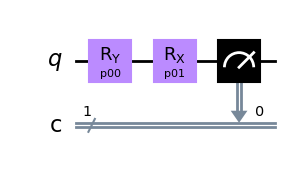

In [10]:
qcpp = create_qcpp(n_params)
qcp = create_processing_qc(qcpp)
qcp_trans = transpile(qcp)
display(qcp_trans.draw())

###The final circuit

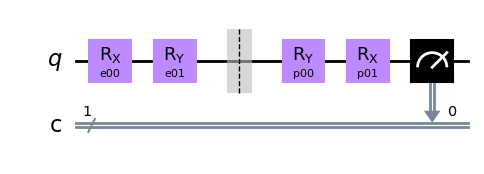

In [11]:
qc_final = qce.compose(qcp)
qc_final_trans = transpile(qc_final)
qc_final_trans.draw()

## The Particle Swarm Optimization

In [12]:
def calculate_cost(expected, obtained):
  #return np.sqrt(((expected - obtained)**2).sum()/len(expected))
  obtBin = [1 if i>0.5 else 0 for i in obtained ]
  return (abs(expected - obtBin)).sum()

In [14]:
# Data
# X - the dataset with features
# y - the expected label

n_particles  =  20
n_iterations =  50
shots=10000
mc  = 0.25 #Momentum coefficient
c1  = 0.25 #Particle memory coefficient
c2  = 0.25 #swarm influence coefficient

class Solution:
  particle = int(0)
  cost = float(1000000000000)
  position = None
  changed = False

#Algorithm Initialization
position   = np.pi*(np.random.rand(n_particles, n_params)*2-1)   #generate random angles between -PI and PI
velocity   = np.pi*(np.random.rand(n_particles, n_params)*2-1)   #generate random angles between -PI and PI

#TODO - best_sol and costs can be considered as a single object
best_sol   = np.copy(position)                                   #initialize the best solution for each particle
costs = {} #current cost for each particle

#Initialization
optimal_sol = Solution()

for p in range(0, n_particles):
  print(f"Initialization - Particle {p}")
  #set the parameters for the particle...
  qc_particle = assign_params(qc_final_trans, qcpp, position[p])
  oneProb = []
  for s in range(0, X.shape[0]):
    #print(f"\tsample {s}")
    #set the input parameters...
    qc_run = assign_params(qc_particle, qcep, X[s])
    counts = run_qc(qc_run, shots)
    try:
      oneProb.append(float(counts['1'])/shots)
    except KeyError:
      oneProb.append(0)
  costs[p] = calculate_cost(y, np.array(oneProb))
  print(f"Cost for particle {p}: {costs[p]}")
  if (optimal_sol.cost > costs[p]):
    print(f"Global best cost found for particle {p}. Old / New Cost: {optimal_sol.cost} / {costs[p]}")
    optimal_sol.particle=p
    optimal_sol.cost=costs[p]
    optimal_sol.changed = True
    optimal_sol.position = position[p]
  print(f"Particle {p} - done")

#Iterations of the Swarm
for i in range(1,n_iterations+1):
  optimal_sol.changed = False
  for p in range(0, n_particles):
    print(f"Iteration {i}, Particle {p}")

    #Re-initialize parameters for particle p
    w = np.random.rand(2, n_params)
    momentum    = mc*velocity[p]
    particle    = c1*w[0]*(best_sol[p] - position[p])
    swarm       = c2*w[1]*(optimal_sol.position - position[p])
    velocity[p] = momentum + particle + swarm
    position[p] = position[p] + velocity[p]

    #set the parameters for the particle...
    qc_particle = assign_params(qc_final_trans, qcpp, position[p])
    oneProb = []
    for s in range(0, X.shape[0]):
      #print(f"\tsample {s}")
      #set the input parameters...
      qc_run = assign_params(qc_particle, qcep, X[s])
      counts = run_qc(qc_run, shots)
      try:
        oneProb.append(float(counts['1'])/shots)
      except KeyError:
        oneProb.append(0)
    cost = calculate_cost(y, np.array(oneProb))
    print(f"Cost for particle {p}: {cost}")
    if (costs[p] > cost):
      print(f"Better local cost found in particle {p}. Old / New Cost: {costs[p]} / {cost}")
      best_sol[p] = position[p]
      costs[p] = cost
      if (optimal_sol.cost > cost):
        print(f"Found GLOBAL best cost in particle {p}. Old Global / New Global: {optimal_sol.cost} / {cost}")
        optimal_sol.particle=p
        optimal_sol.cost=cost
        optimal_sol.changed = True
        optimal_sol.position = position[p]
        if (optimal_sol.cost==0):
          break #found best solution
    print(f"Iteration {i}, Particle {p} - done")

print(f"Best parameters with cost {optimal_sol.cost} are: {optimal_sol.position}")

#print(n_params)
#print(params)

Initialization - Particle 0
Cost for particle 0: 42.0
Global best cost found for particle 0. Old / New Cost: 1000000000000.0 / 42.0
Particle 0 - done
Initialization - Particle 1
Cost for particle 1: 21.0
Global best cost found for particle 1. Old / New Cost: 42.0 / 21.0
Particle 1 - done
Initialization - Particle 2
Cost for particle 2: 47.0
Particle 2 - done
Initialization - Particle 3
Cost for particle 3: 33.0
Particle 3 - done
Initialization - Particle 4
Cost for particle 4: 26.0
Particle 4 - done
Initialization - Particle 5
Cost for particle 5: 23.0
Particle 5 - done
Initialization - Particle 6
Cost for particle 6: 33.0
Particle 6 - done
Initialization - Particle 7
Cost for particle 7: 32.0
Particle 7 - done
Initialization - Particle 8
Cost for particle 8: 28.0
Particle 8 - done
Initialization - Particle 9
Cost for particle 9: 31.0
Particle 9 - done
Initialization - Particle 10
Cost for particle 10: 18.0
Global best cost found for particle 10. Old / New Cost: 21.0 / 18.0
Particle 10

In [15]:
#Based on q qc and the parameters for it, returns the obtained outcome
def getObtained(qc, qcep, qcpp, param, X):
  qc_particle = assign_params(qc, qcpp, param)

  obt = []
  for s in range(0, X.shape[0]):
    qc_run = assign_params(qc_particle, qcep, X[s])
    counts = run_qc(qc_run, shots)
    try:
      obt.append(float(counts['1'])/shots)
    except KeyError:
      obt.append(0)

  return obt, [1 if o > 0.50 else 0 for o in obt ]


#Select only points where there is a mismatch between expected and obtained
def listIncorrectPoints(obtained, expected, X):
  Xf = []
  yo = []
  ye = []
  for i in [idx for (idx, j) in enumerate(obtained != expected) if j == True ]:
    Xf.append(X[i])
    yo.append(obtained[i])
    ye.append(expected[i])

  #Obtained with wrong forecast
  dfoInc = pd.DataFrame(Xf, columns=['feat1', 'feat2'])
  dfoInc['label'] = yo

  #Expected with wrong forecast
  dfeInc = pd.DataFrame(Xf, columns=['feat1', 'feat2'])
  dfeInc['label'] = ye

  return dfoInc, dfeInc

In [16]:
obt, obtBin = getObtained(qc_final_trans, qcep, qcpp, optimal_sol.position, X)
dfoInc, dfeInc = listIncorrectPoints(obtBin, y, X)

In [17]:
dfoInc

feat1     feat2  label
0  0.645527  1.570796      1
1  4.699647  0.879584      0
2  4.712389 -0.660908      0
3  4.615399  1.387719      0
4  4.558580  1.201288      0

In [18]:
#Points which were incorrectly forecasted
XInc = dfoInc[['feat1','feat2']].to_numpy()
yInc = dfoInc[['label']].to_numpy()
display(plot_bloch(XInc, yInc, qce_trans, qcep, colors))

#And All the points in the sample (with expected outcomes, in color)
display(plot_bloch(X, y, qce_trans, qcep, colors))

<ipython-input-19-5d84318fb23d>:19: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



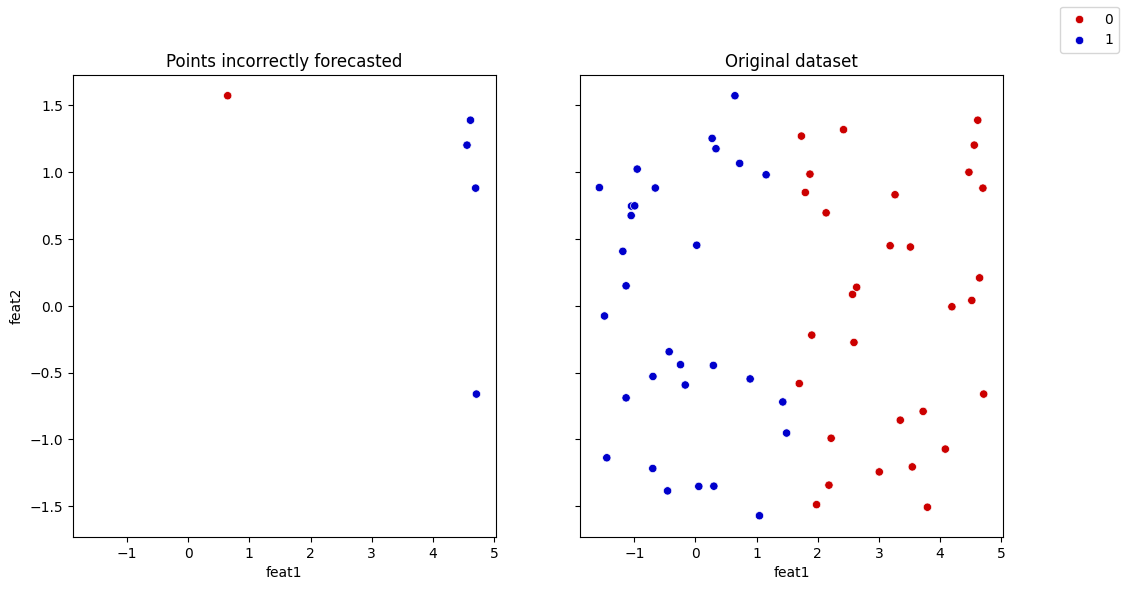

In [19]:
#Points which were incorrectly forecasted
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)


#ax1.set_xlim(0,np.pi)
#ax1.set_ylim(0,2*np.pi)

hue_order=[0,1]

s1 = sns.scatterplot(data=dfoInc, x="feat1", y="feat2", hue="label", palette=colors, ax=ax1, legend=False, hue_order=hue_order)
ax1.set_title("Points incorrectly forecasted")

s2 = sns.scatterplot(data=dsFinal, x="feat1", y="feat2", hue="label", palette=colors, ax=ax2, legend=False, hue_order=hue_order)
ax2.set_title("Original dataset")

#Wrong legend...
fig.legend([s1, s2], labels=['0','1'],
           loc="upper right")

### Based on the optimal parameters, generate results for the entire sphere surface

In [20]:
#Generate results for all the problem space, so that we can visualize the decision border
def genResults(qc, qcpp, qcep, params, f1Interval, f2Interval, f1points=10, f2points=10):
  feat1T = np.linspace(f1Interval[0], f1Interval[1], f1points)
  feat2T = np.linspace(f2Interval[0], f2Interval[1], f2points)

  qc_particle = assign_params(qc, qcpp, params)

  f1T = []
  f2T = []
  yT = []
  for x in feat1T:
    for y in feat2T:
      f1T.append(x)
      f2T.append(y)
      qc_run = assign_params(qc_particle, qcep, [x,y])
      counts = run_qc(qc_run, shots)
      try:
        yT.append(float(counts['1'])/shots)
      except KeyError:
        yT.append(0)

  return pd.DataFrame({'feat1':f1T, 'feat2':f2T, 'label':[1 if o>0.5 else 0 for o in yT]})


#Function to plot the overlay...all means all points in the surface, exp is the expected points (points in the dataset)
def plot_bloch_overlay(Xall, yall, qc, qcep, XExp, yExp, colors, alphaAll=1, alphaExp=1):
#X - Statevectors
#y - zeros or ones
  def adj(xyzs, delta=0.02):
    res = []
    for x,y,z in xyzs:
      x = x + delta if x>0 else x - delta
      y = y + delta if y>0 else y - delta
      z = z + delta if z>0 else z - delta
      res.append([x,y,z])
    return res

  svsAll = []
  for x in Xall:
    qce_ready = assign_params(qc, qcep, x) #parameter input happens here
    sv = Statevector.from_label('0')
    sv = sv.evolve(qce_ready)
    svsAll.append(sv)

  zerosAll = [calcXYZ(sv) for sv, y in zip(svsAll, yall) if y==0  ]
  onesAll  = [calcXYZ(sv) for sv, y in zip(svsAll, yall) if y==1  ]

  svsExp = []
  for x in XExp:
    qce_ready = assign_params(qc, qcep, x) #parameter input happens here
    sv = Statevector.from_label('0')
    sv = sv.evolve(qce_ready)
    svsExp.append(sv)

  zerosExp = [calcXYZ(sv) for sv, y in zip(svsExp, yExp) if y==0  ]
  onesExp  = [calcXYZ(sv) for sv, y in zip(svsExp, yExp) if y==1  ]

  return bloch_sphere(points=[zerosAll, onesAll, adj(zerosExp), adj(onesExp)],
             points_color=colors,
             points_alpha=[alphaAll*np.ones(len(zerosAll)), alphaAll*np.ones(len(onesAll)), alphaExp*np.ones(len(zerosExp)), alphaExp*np.ones(len(onesExp)) ],
             figsize=(500, 500))

In [21]:
f1AllRange = (-np.pi/2, 1.5*np.pi)
f2AllRange = (-np.pi/2, np.pi/2)

dfAllSpace = genResults(qc_final_trans, qcpp, qcep, optimal_sol.position, f1AllRange, f2AllRange, 120, 120 )
Xall = dfAllSpace[['feat1','feat2']].to_numpy()
yall = dfAllSpace[['label']].to_numpy()

In [22]:
colors_overlay= ['#CCE5FF', '#FFCCCC', '#0000cc', '#cc0000']
colors_overlay= ['#66B2FF', '#FF6666', '#0000cc', '#cc0000']
alphaAll=0.8
alphaExp=1
display(plot_bloch_overlay(Xall, yall, qce_trans, qcep, X, y, colors_overlay, alphaAll, alphaExp))

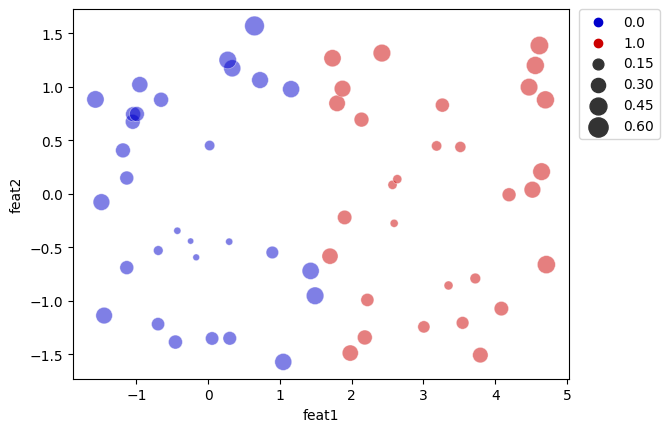

In [23]:
#ploting the marginals
m = abs(y - obt)

#plt.xlim(0,np.pi)
#plt.ylim(0,np.pi)

sns.scatterplot(data=dsFinal, x="feat1", y="feat2", hue="label", size=m, alpha=0.5, sizes=(20,200), palette=colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

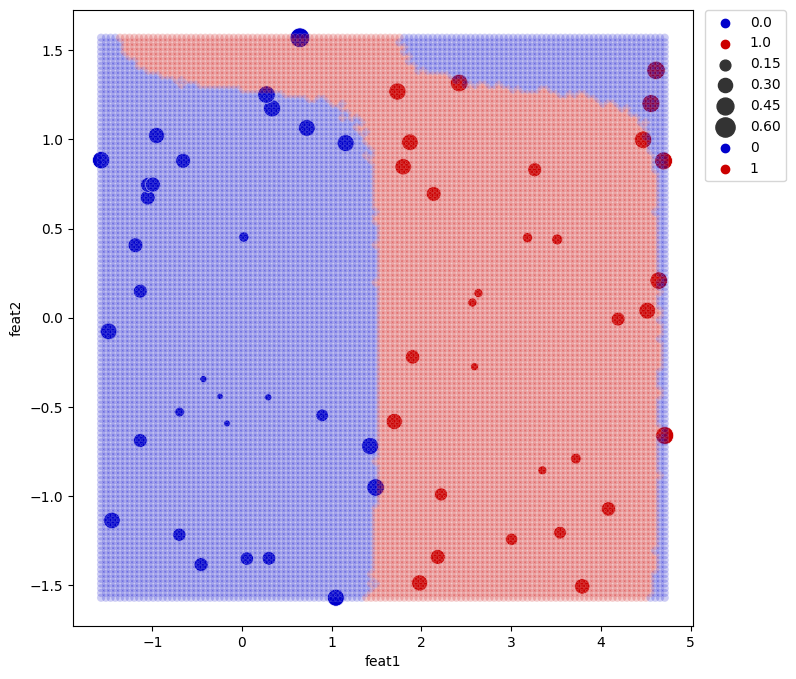

In [24]:
import matplotlib.pyplot as plt


#Surfacing showing how the classifier categorizes each point (in the background)
#Foreground: The expected values for each point in the dataset (with the marginal)
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(data=dsFinal, x='feat1', y='feat2', hue='label', alpha=1, size=m, sizes=(20,200), ax=ax, palette=colors)
sns.scatterplot(data=dfAllSpace, x='feat1', y='feat2', hue='label', alpha=0.2, ax=ax, palette=colors)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)